In [ ]:
### Dependencies instantiation ###

# Only run this cell once, if you haven't run it yet
# This ensures that you have all the necessary dependencies installed

using Pkg
Pkg.activate("../")
Pkg.instantiate()

In [1]:
### Imports ###

include("../src/QuantumPrimer.jl")
using .QuantumPrimer
using Yao
using YaoPlots
using Plots
default(lw=2, ms=5, palette=:Set2_8)
using LinearAlgebra
using Random
using Optimisers
using JLD2

#### Tests

In [2]:
psi1 = rand_state(2)
psi2 = rand_state(2)
u_rand = matblock(rand_unitary(4))
psi1_tilde = copy(psi1) |> u_rand
psi2_tilde = copy(psi2) |> u_rand

println("Overlap before unitary: ", abs2(dot(psi1.state, psi2.state)))
println("Overlap after unitary: ", abs2(dot(psi1_tilde.state, psi2_tilde.state)))

println("Shadow before unitary: ", projected_quantum_kernel(psi1, psi2))
println("Shadow after unitary: ", projected_quantum_kernel(psi1_tilde, psi2_tilde))

Overlap before unitary: 0.12457173385259909
Overlap after unitary: 0.12457173385259916
Shadow before unitary: 0.21043927372073876
Shadow after unitary: 0.5717140979762246


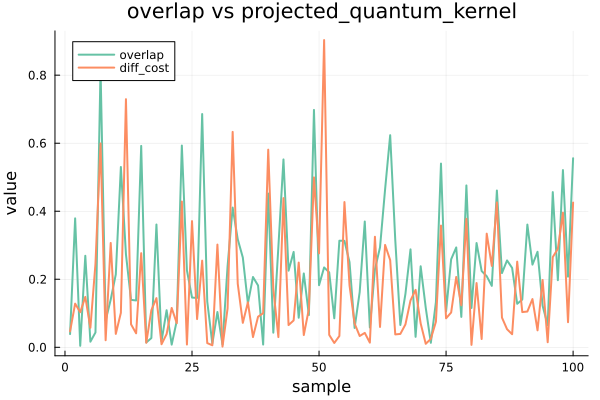

In [ ]:
yy1 = zeros(100)
yy2 = zeros(100)
for i in 1:100
    psi1 = rand_state(2)
    psi2 = rand_state(2)
    yy1[i] = abs2(dot(psi1.state, psi2.state))
    yy2[i] = projected_quantum_kernel(psi1, psi2; gamma=1)
end

Plots.plot(yy1, label="overlap", xlabel="sample", ylabel="value", title="overlap vs projected_quantum_kernel", legend=:topleft)
Plots.plot!(yy2, label="diff_cost")


In [ ]:
Sgate = shift(π/2)
clifford_A = [I2, H, Sgate, H*Sgate, Sgate*H, H*Sgate*H];
clifford_B = [I2, X, Y, Z];
clifford_group = [a*b for a in clifford_A, b in clifford_B];

length(clifford_group) == 24

true

In [ ]:
# circc = sum([chain(2, put(1=>ele/sqrt(2)), put(2=>ele/sqrt(2))) for ele in [I2, X, Y, Z]])
circc = circ_swap_all(2; decompose=true)

state1 = zero_state(1)
state2 = rand_state(1)
state_joined = join(state1, state2)
println(state_joined.state)

state_joined |> circc
println(state_joined.state)


# params = 2pi * rand(nparameters(Utest))

expect(circc, state_joined)
expect(circc, state_joined)

ComplexF64[-0.4569977814126136 - 0.29650238126945144im; -0.8288719877260301 + 0.12732082959435082im; 0.0 - 0.0im; -0.0 + 0.0im;;]
ComplexF64[-0.4569977814126135 - 0.2965023812694514im; 0.0 + 0.0im; -0.8288719877260299 + 0.1273208295943508im; 0.0 + 0.0im;;]


0.2967606343145059

#### Examples: run one cell

In [2]:
### Example: forrelated vs random states ###

data = load("../data/old/forr_rand_fns_n4.jld2")

forr_f = data["single_stored_object"][1]
rand_f = data["single_stored_object"][2]

forr_batch, forr_samples, forr_vec = size(forr_f, 1), size(forr_f[1], 1), size(forr_f[1][1], 1)
rand_batch, rand_samples, rand_vec = size(rand_f, 1), size(rand_f[1], 1), size(rand_f[1][1], 1)

new_forr_f = zeros(Float64, forr_batch, forr_samples, forr_vec)
new_rand_f = zeros(Float64, rand_batch, rand_samples, rand_vec)

for i in 1:forr_batch
    for j in 1:forr_samples
        new_forr_f[i, j, :] = forr_f[i][j]
        new_rand_f[i, j, :] = rand_f[i][j]
    end
end

####### Change to Int -1, 1 ########
new_forr_f = trunc.(Int64, new_forr_f)
new_rand_f = trunc.(Int64, new_rand_f)
forr_f[1][1][:] ≈ new_forr_f[1,1,:] ? println("Loading data: successful") : println("Loading data: failed")
####################################

seed = 1234 # set seed for reproducibility
Random.seed!(seed)

n = 4 # preferably a power of 2

n_samples = 20
states1 = Vector{NTuple{2, ArrayReg}}(undef, 2*n_samples)
states2 = Vector{NTuple{2, ArrayReg}}(undef, 2*n_samples)
psi_zero = zero_state(n)
# psi_zero = zero_state(trunc(Int, log2(n)))
for i in 1:2*n_samples
    states1[i] = (copy(psi_zero) |> circ_hypergraph_state(new_forr_f[i, 1, :]), copy(psi_zero) |> circ_hypergraph_state(new_forr_f[i, 2, :]))
    states2[i] = (copy(psi_zero) |> circ_hypergraph_state(new_rand_f[i, 1, :]), copy(psi_zero) |> circ_hypergraph_state(new_rand_f[i, 2, :]))
end
states1[1][1].state ≈ normalize(new_forr_f[1, 1, :]) ? println("Preparation hypergraph states: successful") : println("Preparation hypergraph states: failed")

# train
tr_states = vcat([states1[1:n_samples], states2[1:n_samples]]...)
tr_labels = vcat([repeat([1], n_samples), repeat([-1], n_samples)]...)

# test
te_states = vcat([states1[n_samples+1:n_samples*2], states2[n_samples+1:n_samples*2]]...)
te_labels = vcat([repeat([1], n_samples), repeat([-1], n_samples)]...)

# structures
d1 = DataSiamese(tr_states, tr_labels);
d2 = DataSiamese(te_states, te_labels);

Loading data: successful
Preparation hypergraph states: successful


#### Model parameters

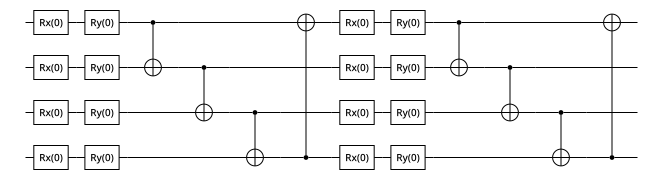

In [4]:
iters = 100 # number of iterations
lr = 0.02  # learning rate. Start with lr=0.1. Reduce to (e.g. lr=0.01) if optimisation is not smooth.
optim = ADAM(lr) # Descent(lr) # See https://fluxml.ai/Optimisers.jl/dev/api/#Optimisation-Rules for different optimisers.

##### Cost #####
cost_fun = circ_swap_all
activation = x -> sigmoid(10x) # default is identity
cost = CircuitCost(cost_fun, activation)
################

##### QCNN #####
# ansatz = circ_Ry_conv # circ_Ry_conv, circ_Ry_simple_conv, circ_SU4_conv
# circ1 = build_QCNN(n, ansatz=ansatz)
# circ2 = build_QCNN(n, ansatz=ansatz)
################

##### QNN #####
ansatz = circ_HEA
depth = 2 # ceil(Int, log2(n))
circ1 = build_QNN(n, depth, ansatz=ansatz)
circ2 = build_QNN(n, depth, ansatz=ansatz)
###############

##### Model #####
model1 = GeneralModel(n=n, circ=circ1, ansatz=ansatz)
model2 = GeneralModel(n=n, circ=circ2, ansatz=ansatz)
# # model1 = InvariantModel(n=n, circ=circ1, ansatz=ansatz) # only valid for QCNN
# # model2 = InvariantModel(n=n, circ=circ2, ansatz=ansatz)
#################

initialize_params(model1);
initialize_params(model2);

YaoPlots.plot(circ1)
# YaoPlots.plot(obs_A*obs_B)

#### Run

In [5]:
models = (model1, model2)
model_results = train_test_model(d1, d2, models, cost, iters, optim; regularization=:nothing, verbose=true);
# model_results = train_test_model(d1, d2, models, cost, iters, optim; lambda=1e-2, regularization=:l1, verbose=true);
# model_results = train_test_model(d1, d2, models, cost, iters, optim; lambda=1e-5, regularization=:l2, verbose=true);

model1_params, model2_params, loss_track, tr_track, te_track, tr_preds, te_preds = model_results;

Initial: loss = 1.4991377380866873, tr_acc = 0.5, te_acc = 0.5
Iteration 20: loss = 1.3433716347070703, tr_acc = 0.5, te_acc = 0.5
Iteration 40: loss = 1.3786682738284397, tr_acc = 0.5, te_acc = 0.5
Iteration 60: loss = 1.3073461088259606, tr_acc = 0.5, te_acc = 0.5
Iteration 80: loss = 1.1576604036920226, tr_acc = 0.5, te_acc = 0.5
Iteration 100: loss = 1.2019263632254622, tr_acc = 0.5, te_acc = 0.5
Final: loss = 1.2019263632254622, tr_acc = 0.5, te_acc = 0.5


#### Plot

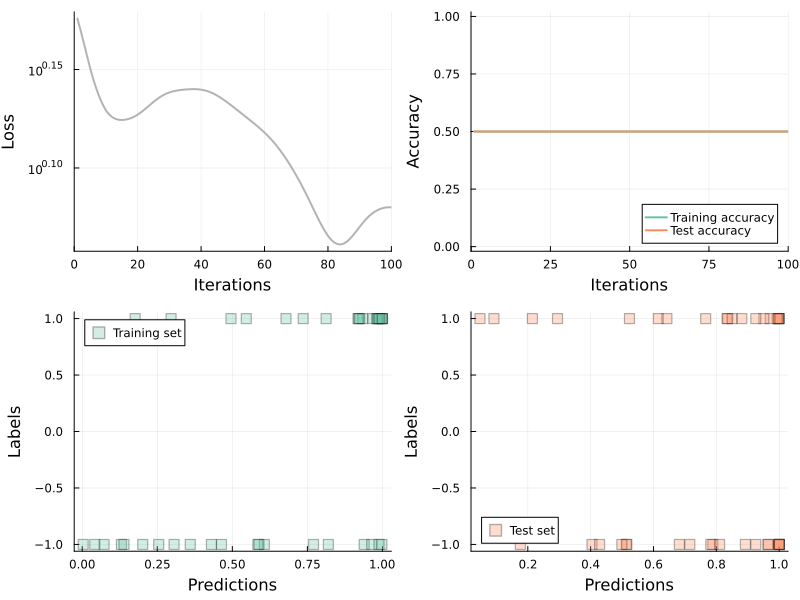

In [6]:
# Loss vs Interations
p1 = Plots.plot(xlim=(0, iters), xlabel="Iterations", ylabel="Loss")
# Plots.hline!([loss_track[1]], label=false, c=0, ylim=(0.9loss_track[1], 1.1loss_track[1]))
Plots.plot!(loss_track, yaxis=:log, label=false, c=0)

# Accuracy vs Interations
p2 = Plots.plot(xlim=(-0.05, iters), ylim=(-0.02, 1.02), xlabel="Iterations", ylabel="Accuracy", legend=:bottomright)
Plots.plot!(tr_track, label="Training accuracy", c=1)
Plots.plot!(te_track, label="Test accuracy", c=2)

# Training labels vs predictions
p3 = Plots.scatter(xlabel="Predictions", ylabel="Labels")
Plots.scatter!(tr_preds, tr_labels, ma=0.3, shape=:rect, label="Training set", c=1)

# Test labels vs predictions
p4 = Plots.scatter(xlabel="Predictions", ylabel="Labels")
Plots.scatter!(te_preds, te_labels, ma=0.3, shape=:rect, label="Test set", c=2)

Plots.plot(p1, p2, p3, p4, layout=(2, 2), size=(800, 600))

In [6]:
# savefig("qcsnn_forr_n4_conv_Ry_overlap.pdf")